# Формализация задачи

В целом, формализация задачи зависит от имеющегося датасета. Если датасет размечен бинарно или на категории (хороший отзыв, плохой, нейтральный), то скорее всего, это будет задача классификации. Если датасет размечен числами (например, по шкале от 0 до 10), то это задача регрессии. Однако, и задачу классификации можно превратить в регрессию (например, предсказывать число от 0 до 1 или отобразить плохой-нейтральный-хороший в 0-1-2), и задачу регрессии в классификацию. Также, если датасет частично размечен или не размечен вообще, то это будет задача кластеризации с последующим упорядочиванием кластеров каким-либо образом.

В моем случае, отзывы были собраны с сайта banki.ru, причем каждый отзыв имеет оценку от 1 до 5 включительно. Отзывы на русском языке, более подробные характеристики будут описаны ниже.

Я буду решать эту задачу как задачу классификации, а точность проверять по полному совпадению классов. Но понятно, что в этом случае при ground truth = 5 ответы 1 и 4 будут одинаково неверными. Поэтому если придумать метрику, которая бы это учитывала, то точность была бы выше. Задачу регрессии решать не очень хочется потому что в этом случае придется придумывать какой-то baseline, с которым надо будет сравнивать ошибку.

Преобразование данных: каждый отзыв будет предобрабатываться с помощью библиотеки `nltk`, это включает в себя:
* приведение к нижнему регистру
* удаление стоп-слов
* стемминг

Векторизация: я беру 100 самых популярных слов и каждый отзыв кодируется в бинарную последовательность длины 100, где позиция `i` это индикатор того, что `i`-тое популярное слово содержится в отзыве.

Классификатор: я пользуюсь наивным байесовским классификатором (не учитывает отношения между словами) из `nltk`.

# Сбор данных

In [1]:
import io
import logging
import json
import pickle
import numpy as np
import seaborn as sns
import nltk
import string

%matplotlib inline

from tqdm import tqdm
from grab import Grab
from grab.spider import Spider, Task
from sklearn.model_selection import StratifiedShuffleSplit

from vectorizer import Vectorizer

# logging.basicConfig(level=logging.DEBUG)

In [2]:
NUM_PAGES = 20  # для каждого банка рассматриваются первые 20 страниц отзывов (или меньше, если отзывов меньше)
NUM_THREADS = 2

class BankiSpider(Spider):  # класс-кроулер
    def __init__(self, **kwargs):
        self.ratings = []
        super(BankiSpider, self).__init__(**kwargs)

    def task_generator(self):
        grab = Grab()
        grab.go('http://www.banki.ru/banks/?order=fin_rating')

        links = grab.doc('//a[contains(@href, "responses/bank")]/@href').text_list()
        urls = map(lambda s: 'http://www.banki.ru' + s, links)
        
        for url in urls:
            yield Task('extract', url=url)
            for page in range(2, NUM_PAGES + 1):
                yield Task('extract', url=url+'?page={}'.format(page))

    def task_extract(self, grab, task):
        for score, text in zip(grab.doc('//div[contains(@class, "responses__item__rating")]').text_list(),
                               grab.doc('//div[contains(@class, "markup-inside-small")]').text_list()):
            if score.find(u'ОЦЕНКА: ') != -1:
                self.ratings.append({
                    'score': score[8],
                    'text': text,
                })

In [3]:
bot = BankiSpider(thread_number=NUM_THREADS)
bot.run()
data = bot.ratings
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

Общее количество собранных отзывов:

In [4]:
len(data)

13175

Пример отзыва и соответствующей оценки:

In [5]:
data[0]

{'score': '1',
 'text': 'Хочу поделиться своей проблемой. В прошлом месяце подал заявление на снижение процентной ставки поипотеке (первичное жилье) и тут как лавина посыпались неприятности со стороны"Сбербанка" сначала пришла СМС с просьбой предоставить документы подтверждающиецелевое использование кредитных средств и это при том, что залог на этунедвижимость был оформлен 2.5 года назад. Позвонил в контакт-центр мне не чеговразумительно объяснить не смогли, а после того пришло голосовое сообщение вкотором мне еще и угрожали штрафами. Обратился отделение в котором мнепредварительно попинав из кабинета в кабинет, опять не чего не объяснили,только посоветовали написать заявление с просьбой разъяснить, что от меняхотят. Потом узнав что я обращался в субботу знакомые подсказали, что в этовремя дежурят подменные некомпетентные сотрудники и нужно обратиться в буднийдень. Я повторно пришел в отделение и наконец мне другой сотрудникразъяснил, что потерялись в базе копии моих документов в том ч

In [6]:
scores = np.array([d['score'] for d in data]).astype(int)

Распределение оценок в собранных отзывах:

In [7]:
np.unique(scores, return_counts=True)

(array([1, 2, 3, 4, 5]), array([6835, 1579,  643,  438, 3680]))

Средняя оценка по всем отзывам:

In [8]:
np.mean(scores)

2.4344592030360532

График распределения оценок:

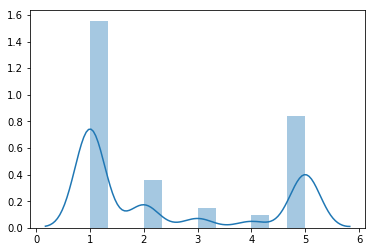

In [9]:
sns.distplot(scores)

In [11]:
vectorizer = Vectorizer()

In [12]:
terms = {}

for i in tqdm(range(len(data))):
    # препроцессинг текста, исходный код в vectorizer.py
    data[i]['text'] = vectorizer.preprocess_text(data[i]['text'])
    
    # считаем популярность слова (с учетом количества вхождений в каждый отзыв)
    for w in data[i]['text']:
        if w in terms:
            terms[w] += 1
        else:
            terms[w] = 1

with open('processed_data.pickle', 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 13175/13175 [13:52<00:00, 15.82it/s]


In [13]:
# берем 100 самых популярных слов
terms = np.array(list(terms.items()))
ind = np.argsort(-terms[:, 1].astype(int))
terms = terms[ind, 0][:100]

vectorizer.set_terms(terms)

Топ-10 наиболее популярных слов:

In [14]:
terms[:10]

array(['банк', 'карт', 'эт', 'сотрудник', 'котор', 'мо', 'клиент', 'счет',
       'отделен', 'деньг'],
      dtype='<U39')

In [ ]:
# with open('processed_data.pickle', 'rb') as f:
#     data = pickle.load(f)

Пример отзыва после обработки:

In [15]:
print(data[0])

{'score': '1', 'text': ['хоч', 'подел', 'сво', 'проблем', 'прошл', 'месяц', 'пода', 'заявлен', 'снижен', 'процентн', 'ставк', 'поипотек', 'первичн', 'жил', 'лавин', 'посыпа', 'неприятн', 'сторон', 'сбербанк', 'снача', 'пришл', 'смс', 'просьб', 'предостав', 'документ', 'подтверждающиецелев', 'использован', 'кредитн', 'средств', 'эт', 'залог', 'этунедвижим', 'оформл', 'год', 'назад', 'позвон', 'чеговразумительн', 'объясн', 'смогл', 'пришл', 'голосов', 'сообщен', 'вкотор', 'угрожа', 'штраф', 'обрат', 'отделен', 'котор', 'мнепредварительн', 'попина', 'кабинет', 'кабинет', 'объясн', 'посоветова', 'написа', 'заявлен', 'просьб', 'разъясн', 'меняхот', 'узна', 'обраща', 'суббот', 'знаком', 'подсказа', 'этоврем', 'дежур', 'подмен', 'некомпетентн', 'сотрудник', 'нужн', 'обрат', 'буднийден', 'повторн', 'пришел', 'отделен', 'сотрудникразъясн', 'потеря', 'баз', 'коп', 'мо', 'документ', 'числ', 'самкредитн', 'договор', 'пок', 'запрос', 'архив', 'начисленштраф', 'подела', 'кром', 'извин', 'дела', 'неч

Минимальная, средняя и максимальная длины отзывов после удаления стоп-слов:

In [16]:
lengths = np.array([len(d['text']) for d in data])
lengths.min(), lengths.mean(), lengths.max()

(5, 116.49017077798861, 2334)

Преобразование отзыва в вектор фич:

In [17]:
features = [(vectorizer.get_features(d['text']), int(d['score'])) for d in data]

with open('features.pickle', 'wb') as f:
    pickle.dump(features, f)

In [ ]:
with open('features.pickle', 'rb') as f:
    features = pickle.load(f)

Разделение датасета на `train` и `test` с сохранением распределений по классам:

In [18]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X=[f[0] for f in features], y=[f[1] for f in features]):
    train = [features[i] for i in train_index]
    test = [features[i] for i in test_index]

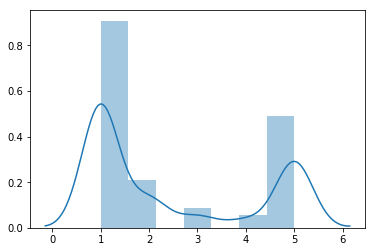

In [19]:
sns.distplot([t[1] for t in test])

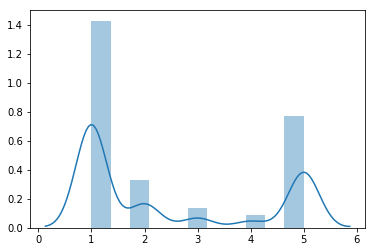

In [20]:
sns.distplot([t[1] for t in train])

# Построение модели

In [21]:
classifier = nltk.NaiveBayesClassifier.train(train)

Полученная точность классификации:

In [22]:
nltk.classify.accuracy(classifier, test)

0.6197343453510437

Примеры наиболее значимых фич:

In [23]:
classifier.show_most_informative_features(5)

Most Informative Features
                w_спасиб = True                5 : 1      =      8.5 : 1.0
                   w_поч = True                2 : 5      =      7.8 : 1.0
                 w_горяч = True                1 : 5      =      5.8 : 1.0
                   w_лин = True                1 : 5      =      5.7 : 1.0
                 w_номер = True                1 : 5      =      5.2 : 1.0


Примеры классификации (они же на скриншотах демки):

In [24]:
classifier.classify(vectorizer.get_features('''
    сотрудники доброжелательны, хочу поблагодарить
'''))

5

In [25]:
classifier.classify(vectorizer.get_features('''
    почему так плохо? номер горячей линии все время занят, на сообщения и смс не отвечают
'''))

1

In [26]:
with open('classifier.pickle', 'wb') as f:
    pickle.dump(classifier, f)

In [27]:
with open('vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)